### Model Training

In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
import joblib  # for saving the scaler

In [10]:
def load_data(index="FD004", features=[2, 3, 4, 7, 11, 12, 15]):
    path = os.getcwd()
    train = np.loadtxt(os.path.join(path, f"train_{index}.txt"))
    test = np.loadtxt(os.path.join(path, f"test_{index}.txt"))
    labels = np.loadtxt(os.path.join(path, f"RUL_{index}.txt"))

    col_names = ["unit_number", "time"] + \
                [f"op_setting{i}" for i in range(1, 4)] + \
                [f"sensor{i}" for i in range(1, 22)]

    train_df = pd.DataFrame(train, columns=col_names)
    test_df = pd.DataFrame(test, columns=col_names)

    selected_features = [f"sensor{i}" for i in features]
    columns = ["unit_number", "time"] + selected_features

    print(f"\n--- Dataset {index} ---")
    print("Selected Sensor Features:", selected_features)
    print("\nTrain Data (first 5 rows):")
    print(train_df[columns].head())
    print("Train Data Shape:", train_df[columns].shape)
    print("\nTest Data (first 5 rows):")
    print(test_df[columns].head())
    print("Test Data Shape:", test_df[columns].shape)

    return train_df[columns], test_df[columns], labels

In [11]:
def compute_rul(df):
    rul = df.groupby("unit_number")["time"].max().reset_index()
    rul.columns = ["unit_number", "max_time"]
    df = df.merge(rul, on="unit_number")
    df["RUL"] = df["max_time"] - df["time"]
    return df.drop(columns=["max_time"])

In [12]:
def scale_and_split(train_df, sequence_length=50):
    features = train_df.columns.difference(["unit_number", "time", "RUL"])
    scaler = MinMaxScaler()
    train_df[features] = scaler.fit_transform(train_df[features])

    sequences, labels = [], []

    for _, group in train_df.groupby("unit_number"):
        group = group.reset_index(drop=True)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq[features].values)
            labels.append(seq["RUL"].values[-1])

    X = np.array(sequences)
    y = np.array(labels)
    return train_test_split(X, y, test_size=0.2, random_state=42), scaler

In [13]:
def prepare_test_data(test_df, rul_labels, scaler, sequence_length=50):
    features = test_df.columns.difference(["unit_number", "time"])
    test_df[features] = scaler.transform(test_df[features])

    sequences = []
    for _, group in test_df.groupby("unit_number"):
        group = group.reset_index(drop=True)
        if len(group) >= sequence_length:
            seq = group.iloc[-sequence_length:]
            sequences.append(seq[features].values)
        else:
            padding = np.zeros((sequence_length - len(group), len(features)))
            seq = np.vstack((padding, group[features].values))
            sequences.append(seq)

    X_test = np.array(sequences)
    y_test = rul_labels
    return X_test, y_test

In [14]:
def build_lstm_model(input_shape):
    model = Sequential([
        Masking(mask_value=0., input_shape=input_shape),
        LSTM(64, return_sequences=True),         # First LSTM Layer
        LSTM(32, return_sequences=False),        # Second LSTM Layer
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [15]:
def train_on_all_datasets():
    dataset_indices = ["FD001", "FD002", "FD003", "FD004"]
    sensor_features = [2, 3, 4, 7, 11, 12, 15]

    results = {}

    for index in dataset_indices:
        print(f"\n--- Training on {index} ---")
        train_df, test_df, rul_labels = load_data(index=index, features=sensor_features)
        train_df = compute_rul(train_df)

        (X_train, X_val, y_train, y_val), scaler = scale_and_split(train_df)

        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

        model = build_lstm_model(input_shape=X_train.shape[1:])
        es = EarlyStopping(patience=10, restore_best_weights=True)

        model.fit(X_train, y_train, epochs=35, batch_size=64,
                  validation_data=(X_val, y_val), callbacks=[es], verbose=2)

        val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation Evaluation for {index}: MSE = {val_loss:.4f}, MAE = {val_mae:.4f}")

        X_test, y_test = prepare_test_data(test_df, rul_labels, scaler)
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Evaluation for {index}: MSE = {test_loss:.4f}, MAE = {test_mae:.4f}")

        model_dir = f"model_{index}"
        os.makedirs(model_dir, exist_ok=True)
        model.save(os.path.join(model_dir, "rul_lstm_model.h5"))
        joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

        results[index] = {
            "Val_MSE": val_loss, "Val_MAE": val_mae,
            "Test_MSE": test_loss, "Test_MAE": test_mae
        }

    print("\n--- Final Evaluation Summary ---")
    for k, v in results.items():
        print(f"{k}: Val_MSE = {v['Val_MSE']:.4f}, Val_MAE = {v['Val_MAE']:.4f}, "
              f"Test_MSE = {v['Test_MSE']:.4f}, Test_MAE = {v['Test_MAE']:.4f}")

In [16]:
if __name__ == "__main__":
    train_on_all_datasets()


--- Training on FD001 ---

--- Dataset FD001 ---
Selected Sensor Features: ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor11', 'sensor12', 'sensor15']

Train Data (first 5 rows):
   unit_number  time  sensor2  sensor3  sensor4  sensor7  sensor11  sensor12  \
0          1.0   1.0   641.82  1589.70  1400.60   554.36     47.47    521.66   
1          1.0   2.0   642.15  1591.82  1403.14   553.75     47.49    522.28   
2          1.0   3.0   642.35  1587.99  1404.20   554.26     47.27    522.42   
3          1.0   4.0   642.35  1582.79  1401.87   554.45     47.13    522.86   
4          1.0   5.0   642.37  1582.85  1406.22   554.00     47.28    522.19   

   sensor15  
0    8.4195  
1    8.4318  
2    8.4178  
3    8.3682  
4    8.4294  
Train Data Shape: (20631, 9)

Test Data (first 5 rows):
   unit_number  time  sensor2  sensor3  sensor4  sensor7  sensor11  sensor12  \
0          1.0   1.0   643.02  1585.29  1398.21   553.90     47.20    521.72   
1          1.0   2.0   641.71  158

/Users/ompandit/Desktop/RUL/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


196/196 - 7s - 38ms/step - loss: 7289.1362 - mae: 66.4638 - val_loss: 4038.5276 - val_mae: 48.5431
Epoch 2/35
196/196 - 6s - 30ms/step - loss: 3454.4421 - mae: 46.6877 - val_loss: 3281.5642 - val_mae: 45.8176
Epoch 3/35
196/196 - 6s - 30ms/step - loss: 3361.2859 - mae: 46.7706 - val_loss: 3283.4683 - val_mae: 45.7879
Epoch 4/35
196/196 - 6s - 30ms/step - loss: 3346.5371 - mae: 46.6395 - val_loss: 3279.8511 - val_mae: 45.8633
Epoch 5/35
196/196 - 6s - 30ms/step - loss: 3348.0127 - mae: 46.7204 - val_loss: 3279.8640 - val_mae: 45.8627
Epoch 6/35
196/196 - 6s - 31ms/step - loss: 3362.1560 - mae: 46.7953 - val_loss: 3282.4116 - val_mae: 45.8021
Epoch 7/35
196/196 - 6s - 31ms/step - loss: 3368.1702 - mae: 46.8396 - val_loss: 3283.5652 - val_mae: 45.7860
Epoch 8/35
196/196 - 6s - 30ms/step - loss: 3361.1538 - mae: 46.7510 - val_loss: 3265.9382 - val_mae: 45.7247
Epoch 9/35
196/196 - 6s - 30ms/step - loss: 2476.9163 - mae: 37.5077 - val_loss: 1237.9318 - val_mae: 24.1035
Epoch 10/35
196/196 -

Validation Evaluation for FD001: MSE = 653.5135, MAE = 17.6137
X_test shape: (100, 50, 7), y_test shape: (100,)
Test Evaluation for FD001: MSE = 500.9026, MAE = 14.8321

--- Training on FD002 ---

--- Dataset FD002 ---
Selected Sensor Features: ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor11', 'sensor12', 'sensor15']

Train Data (first 5 rows):
   unit_number  time  sensor2  sensor3  sensor4  sensor7  sensor11  sensor12  \
0          1.0   1.0   555.32  1358.61  1137.23   194.64     42.02    183.06   
1          1.0   2.0   549.90  1353.22  1125.78   138.51     42.20    130.42   
2          1.0   3.0   537.31  1256.76  1047.45   175.71     36.69    164.22   
3          1.0   4.0   549.51  1354.03  1126.38   138.46     41.96    130.72   
4          1.0   5.0   537.07  1257.71  1047.93   175.05     36.89    164.31   

   sensor15  
0    9.3461  
1    9.3774  
2   10.8941  
3    9.3528  
4   10.8963  
Train Data Shape: (53759, 9)

Test Data (first 5 rows):
   unit_number  time  sen

/Users/ompandit/Desktop/RUL/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


510/510 - 17s - 33ms/step - loss: 4879.9653 - mae: 54.1941 - val_loss: 3476.0310 - val_mae: 47.4840
Epoch 2/35
510/510 - 15s - 30ms/step - loss: 3348.6819 - mae: 46.6085 - val_loss: 3475.4692 - val_mae: 47.4929
Epoch 3/35
510/510 - 15s - 30ms/step - loss: 3361.3948 - mae: 46.6863 - val_loss: 3478.5505 - val_mae: 47.4497
Epoch 4/35
510/510 - 15s - 30ms/step - loss: 3355.2024 - mae: 46.6745 - val_loss: 3482.9866 - val_mae: 47.4088
Epoch 5/35
510/510 - 15s - 30ms/step - loss: 3354.7942 - mae: 46.5947 - val_loss: 3472.9197 - val_mae: 47.5461
Epoch 6/35
510/510 - 15s - 30ms/step - loss: 3350.0076 - mae: 46.6465 - val_loss: 3471.7878 - val_mae: 47.5847
Epoch 7/35
510/510 - 15s - 30ms/step - loss: 3341.1287 - mae: 46.5460 - val_loss: 3481.6121 - val_mae: 47.4205
Epoch 8/35
510/510 - 15s - 30ms/step - loss: 3341.4651 - mae: 46.5867 - val_loss: 3472.1111 - val_mae: 47.7931
Epoch 9/35
510/510 - 15s - 30ms/step - loss: 3334.4041 - mae: 46.5567 - val_loss: 3480.7910 - val_mae: 47.4279
Epoch 10/35


Validation Evaluation for FD002: MSE = 921.2772, MAE = 20.9623
X_test shape: (259, 50, 7), y_test shape: (259,)
Test Evaluation for FD002: MSE = 908.0934, MAE = 21.3226

--- Training on FD003 ---

--- Dataset FD003 ---
Selected Sensor Features: ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor11', 'sensor12', 'sensor15']

Train Data (first 5 rows):
   unit_number  time  sensor2  sensor3  sensor4  sensor7  sensor11  sensor12  \
0          1.0   1.0   642.36  1583.23  1396.84   553.97     47.30    522.31   
1          1.0   2.0   642.50  1584.69  1396.89   554.55     47.23    522.42   
2          1.0   3.0   642.18  1582.35  1405.61   554.43     47.22    522.03   
3          1.0   4.0   642.92  1585.61  1392.27   555.21     47.24    522.49   
4          1.0   5.0   641.68  1588.63  1397.65   554.74     47.15    522.58   

   sensor15  
0    8.4246  
1    8.4403  
2    8.3901  
3    8.3878  
4    8.3869  
Train Data Shape: (24720, 9)

Test Data (first 5 rows):
   unit_number  time  sen

/Users/ompandit/Desktop/RUL/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


247/247 - 9s - 35ms/step - loss: 14707.8311 - mae: 89.0896 - val_loss: 8573.8506 - val_mae: 67.6038
Epoch 2/35
247/247 - 7s - 30ms/step - loss: 8322.0518 - mae: 69.8261 - val_loss: 8000.8042 - val_mae: 68.9185
Epoch 3/35
247/247 - 8s - 30ms/step - loss: 8306.5010 - mae: 70.4546 - val_loss: 8003.2578 - val_mae: 68.8220
Epoch 4/35
247/247 - 8s - 30ms/step - loss: 8312.8242 - mae: 70.5328 - val_loss: 7998.3477 - val_mae: 69.0707
Epoch 5/35
247/247 - 8s - 31ms/step - loss: 8321.3633 - mae: 70.6533 - val_loss: 8006.0498 - val_mae: 68.7354
Epoch 6/35
247/247 - 7s - 30ms/step - loss: 8329.8389 - mae: 70.5418 - val_loss: 8002.8970 - val_mae: 68.8342
Epoch 7/35
247/247 - 8s - 31ms/step - loss: 8296.3105 - mae: 70.4943 - val_loss: 7995.5005 - val_mae: 69.2349
Epoch 8/35
247/247 - 8s - 30ms/step - loss: 6421.3877 - mae: 57.8829 - val_loss: 3542.3726 - val_mae: 40.7911
Epoch 9/35
247/247 - 8s - 31ms/step - loss: 3297.8789 - mae: 38.6400 - val_loss: 2871.2446 - val_mae: 38.0477
Epoch 10/35
247/247 

Validation Evaluation for FD003: MSE = 1606.2811, MAE = 25.6321
X_test shape: (100, 50, 7), y_test shape: (100,)
Test Evaluation for FD003: MSE = 863.6239, MAE = 20.2838

--- Training on FD004 ---

--- Dataset FD004 ---
Selected Sensor Features: ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor11', 'sensor12', 'sensor15']

Train Data (first 5 rows):
   unit_number  time  sensor2  sensor3  sensor4  sensor7  sensor11  sensor12  \
0          1.0   1.0   549.68  1343.43  1112.93   137.36     41.69    129.78   
1          1.0   2.0   606.07  1477.61  1237.50   332.10     43.94    312.59   
2          1.0   3.0   548.95  1343.12  1117.05   138.18     41.66    129.62   
3          1.0   4.0   548.70  1341.24  1118.03   137.98     41.68    129.80   
4          1.0   5.0   536.10  1255.23  1033.59   174.82     36.48    164.11   

   sensor15  
0    9.3335  
1    9.1913  
2    9.4007  
3    9.3369  
4   10.8366  
Train Data Shape: (61249, 9)

Test Data (first 5 rows):
   unit_number  time  se

/Users/ompandit/Desktop/RUL/.venv/lib/python3.11/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


610/610 - 20s - 32ms/step - loss: 8413.0195 - mae: 70.6191 - val_loss: 6437.0034 - val_mae: 63.7033
Epoch 2/35
610/610 - 19s - 30ms/step - loss: 6387.3828 - mae: 63.8547 - val_loss: 6437.0396 - val_mae: 63.9176
Epoch 3/35
610/610 - 19s - 31ms/step - loss: 6390.9165 - mae: 63.9059 - val_loss: 6436.4644 - val_mae: 63.8248
Epoch 4/35
610/610 - 18s - 30ms/step - loss: 6396.8486 - mae: 63.8979 - val_loss: 6436.4521 - val_mae: 63.8173
Epoch 5/35
610/610 - 19s - 31ms/step - loss: 6374.6660 - mae: 63.7926 - val_loss: 6436.9258 - val_mae: 63.7104
Epoch 6/35
610/610 - 19s - 30ms/step - loss: 6349.8857 - mae: 63.6628 - val_loss: 6438.0176 - val_mae: 63.6352
Epoch 7/35
610/610 - 19s - 30ms/step - loss: 6383.7759 - mae: 63.8583 - val_loss: 6439.4834 - val_mae: 63.5743
Epoch 8/35
610/610 - 18s - 30ms/step - loss: 6365.3120 - mae: 63.7266 - val_loss: 6436.9736 - val_mae: 63.9113
Epoch 9/35
610/610 - 19s - 31ms/step - loss: 6389.3120 - mae: 63.8719 - val_loss: 6438.4678 - val_mae: 64.0194
Epoch 10/35


Validation Evaluation for FD004: MSE = 2425.7832, MAE = 33.7897
X_test shape: (248, 50, 7), y_test shape: (248,)
Test Evaluation for FD004: MSE = 1711.8901, MAE = 29.6642

--- Final Evaluation Summary ---
FD001: Val_MSE = 653.5135, Val_MAE = 17.6137, Test_MSE = 500.9026, Test_MAE = 14.8321
FD002: Val_MSE = 921.2772, Val_MAE = 20.9623, Test_MSE = 908.0934, Test_MAE = 21.3226
FD003: Val_MSE = 1606.2811, Val_MAE = 25.6321, Test_MSE = 863.6239, Test_MAE = 20.2838
FD004: Val_MSE = 2425.7832, Val_MAE = 33.7897, Test_MSE = 1711.8901, Test_MAE = 29.6642


### PREDICTION

In [50]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [51]:
def load_test_data(index="FD001", features=[2, 3, 4, 7, 11, 12, 15]):
    """
    Load the test data and RUL labels for a given dataset index.
    """
    path = os.getcwd()
    test_file = os.path.join(path, f"test_{index}.txt")
    rul_file = os.path.join(path, f"RUL_{index}.txt")
    
    test = np.loadtxt(test_file)
    rul = np.loadtxt(rul_file)

    col_names = ["unit_number", "time"] + \
                [f"op_setting{i}" for i in range(1, 4)] + \
                [f"sensor{i}" for i in range(1, 22)]

    test_df = pd.DataFrame(test, columns=col_names)
    selected_features = [f"sensor{i}" for i in features]
    columns = ["unit_number", "time"] + selected_features
    return test_df[columns], rul

In [52]:
def prepare_test_sequences(test_df, rul_labels, sequence_length=50, scaler=None):
    """
    Prepare sequences of fixed length for LSTM input.
    Optionally, use a pre-loaded scaler for scaling features.
    """
    features = test_df.columns.difference(["unit_number", "time"])
    
    # Scale features
    scaler = MinMaxScaler()
    test_df[features] = scaler.fit_transform(test_df[features])
    
    seq_data = []
    actual_rul = []

    for i, (_, group) in enumerate(test_df.groupby("unit_number")):
        group = group.reset_index(drop=True)
        if len(group) >= sequence_length:
            seq = group.iloc[-sequence_length:][features].values
        else:
            pad = np.zeros((sequence_length - len(group), len(features)))
            seq = np.vstack((pad, group[features].values))
        seq_data.append(seq)
        actual_rul.append(rul_labels[i])

    return np.array(seq_data), np.array(actual_rul)

In [56]:
def load_scaler(index="FD001"):
    """
    Load the saved scaler object from model directory.
    """
    path = os.getcwd()
    scaler_path = os.path.join(path, f"model_{index}", "scaler.pkl")
    if os.path.exists(scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = None
        return scaler
    else:
        print(f"No scaler found at {scaler_path}. Using new scaler.")
        return None

In [58]:
def predict_rul_for_dataset(index="FD001"):
    print(f"\n--- Predicting for {index} ---")

    path = os.getcwd()
    model_dir = os.path.join(path, f"model_{index}")
    model_path = os.path.join(model_dir, "rul_lstm_model.h5")

    if not os.path.exists(model_path):
        print(f"Model not found for {index} at {model_path}. Train it first or check path.")
        return

    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    features = [2, 3, 4, 7, 11, 12, 15]

    # Load scaler
    scaler = load_scaler(index=index)

    # Load test data and prepare sequences using the scaler
    test_df, rul_labels = load_test_data(index=index, features=features)
    X_test, y_true = prepare_test_sequences(test_df, rul_labels, scaler=scaler)

    y_pred = model.predict(X_test).flatten()

    for i in range(min(10, len(y_true))):
        print(f"Unit {i+1}: Actual RUL = {y_true[i]:.1f}, Predicted RUL = {y_pred[i]:.1f}")

    mse = np.mean((y_pred - y_true)**2)
    mae = np.mean(np.abs(y_pred - y_true))
    print(f"\nTest MSE: {mse:.4f}, Test MAE: {mae:.4f}")

In [59]:
if __name__ == "__main__":
    for dataset in ["FD001", "FD002", "FD003", "FD004"]:
        predict_rul_for_dataset(dataset)


--- Predicting for FD001 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Unit 1: Actual RUL = 112.0, Predicted RUL = 73.6
Unit 2: Actual RUL = 98.0, Predicted RUL = 101.4
Unit 3: Actual RUL = 69.0, Predicted RUL = 28.4
Unit 4: Actual RUL = 82.0, Predicted RUL = 54.0
Unit 5: Actual RUL = 91.0, Predicted RUL = 63.9
Unit 6: Actual RUL = 93.0, Predicted RUL = 91.7
Unit 7: Actual RUL = 91.0, Predicted RUL = 115.4
Unit 8: Actual RUL = 95.0, Predicted RUL = 43.4
Unit 9: Actual RUL = 111.0, Predicted RUL = 96.1
Unit 10: Actual RUL = 96.0, Predicted RUL = 58.8

Test MSE: 897.9151, Test MAE: 23.5808

--- Predicting for FD002 ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Unit 1: Actual RUL = 18.0, Predicted RUL = 8.3
Unit 2: Actual RUL = 79.0, Predicted RUL = 123.4
Unit 3: Actual RUL = 106.0, Predicted RUL = 106.6
Unit 4: Actual RUL = 110.0, Predicted RUL = 51.9
Unit 5: Actual RUL = 15.0, Predicted RUL = 15.9
Unit 6: Actual RUL = 155.0, Predicted RUL = 143.1
Unit 7: Actual RUL = 6.0, Predicted RUL = 6.8
U

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Unit 1: Actual RUL = 22.0, Predicted RUL = 93.6
Unit 2: Actual RUL = 39.0, Predicted RUL = 50.2
Unit 3: Actual RUL = 107.0, Predicted RUL = 87.8
Unit 4: Actual RUL = 75.0, Predicted RUL = 115.6
Unit 5: Actual RUL = 149.0, Predicted RUL = 85.0
Unit 6: Actual RUL = 78.0, Predicted RUL = 130.0
Unit 7: Actual RUL = 94.0, Predicted RUL = 75.2
Unit 8: Actual RUL = 14.0, Predicted RUL = 9.6
Unit 9: Actual RUL = 99.0, Predicted RUL = 147.3
Unit 10: Actual RUL = 162.0, Predicted RUL = 148.4

Test MSE: 1479.1195, Test MAE: 27.3043


### Visualisation

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [78]:
def load_data(index="FD001", features=[2, 3, 4, 7, 11, 12, 15]):
    path = os.getcwd()
    test_path = os.path.join(path, f"test_{index}.txt")
    label_path = os.path.join(path, f"RUL_{index}.txt")

    if not os.path.exists(test_path) or not os.path.exists(label_path):
        print(f"Missing test or label file for {index}. Skipping...")
        return None, None

    test = np.loadtxt(test_path)
    labels = np.loadtxt(label_path)

    col_names = ["unit_number", "time"] + \
                [f"op_setting{i}" for i in range(1, 4)] + \
                [f"sensor{i}" for i in range(1, 22)]

    test_df = pd.DataFrame(test, columns=col_names)
    selected_features = [f"sensor{i}" for i in features]
    columns = ["unit_number", "time"] + selected_features
    return test_df[columns], labels

In [79]:
def prepare_test_sequences(test_df, rul_labels, sequence_length=50):
    features = test_df.columns.difference(["unit_number", "time"])
    scaler = MinMaxScaler()
    test_df[features] = scaler.fit_transform(test_df[features])

    sequences = []
    true_rul = []

    for idx, (unit, group) in enumerate(test_df.groupby("unit_number")):
        group = group.reset_index(drop=True)
        if len(group) >= sequence_length:
            last_seq = group.iloc[-sequence_length:][features].values
        else:
            pad = np.zeros((sequence_length - len(group), len(features)))
            last_seq = np.vstack((pad, group[features].values))
        sequences.append(last_seq)
        true_rul.append(rul_labels[idx])

    return np.array(sequences), np.array(true_rul)

In [80]:
def plot_rul_predictions(true_rul, predicted_rul, index="FD001"):
    error = np.abs(true_rul - predicted_rul)

    # Line plot
    plt.figure(figsize=(12, 5))
    plt.plot(true_rul, label="Actual RUL", marker='o')
    plt.plot(predicted_rul, label="Predicted RUL", marker='x')
    plt.title(f"RUL Predictions vs Actuals - {index}")
    plt.xlabel("Test Unit Index")
    plt.ylabel("Remaining Useful Life (RUL)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Error plot
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(error)), error, color='tomato', alpha=0.7)
    plt.title(f"Absolute Error per Unit - {index}")
    plt.xlabel("Test Unit Index")
    plt.ylabel("Absolute Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [89]:
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

def predict_rul_for_dataset(index="FD001", features=[2, 3, 4, 7, 11, 12, 15]):
    print(f"\n🔍 Predicting for {index}...")

    # Load test data and RUL labels
    test_df, labels = load_data(index=index, features=features)
    if test_df is None or labels is None:
        return None

    # Prepare sequences
    X_test, true_rul = prepare_test_sequences(test_df, labels)

    # Construct path to the model inside the appropriate folder
    model_folder = f"model_{index}"
    model_filename = "rul_lstm_model.h5"
    model_path = os.path.join(model_folder, model_filename)

    # Check model file existence
    if not os.path.exists(model_path):
        print(f"Model file not found at {model_path}. Skipping...")
        return None

    # Load and compile the model
    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Predict RUL
    predicted_rul = model.predict(X_test).flatten()

    # Print predictions
    for i in range(len(true_rul)):
        print(f"Unit {i+1}: Actual RUL = {true_rul[i]:.1f}, Predicted RUL = {predicted_rul[i]:.1f}")

    # Evaluate
    test_mse = mean_squared_error(true_rul, predicted_rul)
    test_mae = mean_absolute_error(true_rul, predicted_rul)

    print(f"{index} → Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")

    # Plot
    plot_rul_predictions(true_rul, predicted_rul, index)

    return {
        "Dataset": index,
        "MSE": test_mse,
        "MAE": test_mae
    }


🔍 Predicting for FD001...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Unit 1: Actual RUL = 112.0, Predicted RUL = 73.6
Unit 2: Actual RUL = 98.0, Predicted RUL = 101.4
Unit 3: Actual RUL = 69.0, Predicted RUL = 28.4
Unit 4: Actual RUL = 82.0, Predicted RUL = 54.0
Unit 5: Actual RUL = 91.0, Predicted RUL = 63.9
Unit 6: Actual RUL = 93.0, Predicted RUL = 91.7
Unit 7: Actual RUL = 91.0, Predicted RUL = 115.4
Unit 8: Actual RUL = 95.0, Predicted RUL = 43.4
Unit 9: Actual RUL = 111.0, Predicted RUL = 96.1
Unit 10: Actual RUL = 96.0, Predicted RUL = 58.8
Unit 11: Actual RUL = 97.0, Predicted RUL = 41.2
Unit 12: Actual RUL = 124.0, Predicted RUL = 82.6
Unit 13: Actual RUL = 95.0, Predicted RUL = 53.8
Unit 14: Actual RUL = 107.0, Predicted RUL = 56.7
Unit 15: Actual RUL = 83.0, Predicted RUL = 111.8
Unit 16: Actual RUL = 84.0, Predicted RUL = 130.2
Unit 17: Actual RUL = 50.0, Predicted RUL = 40.1
Unit 18: Actual RUL = 28.0, Predicted RUL = 20.8
Unit 19: Actual RUL = 87.0, Predicted RUL = 68.9
Unit 

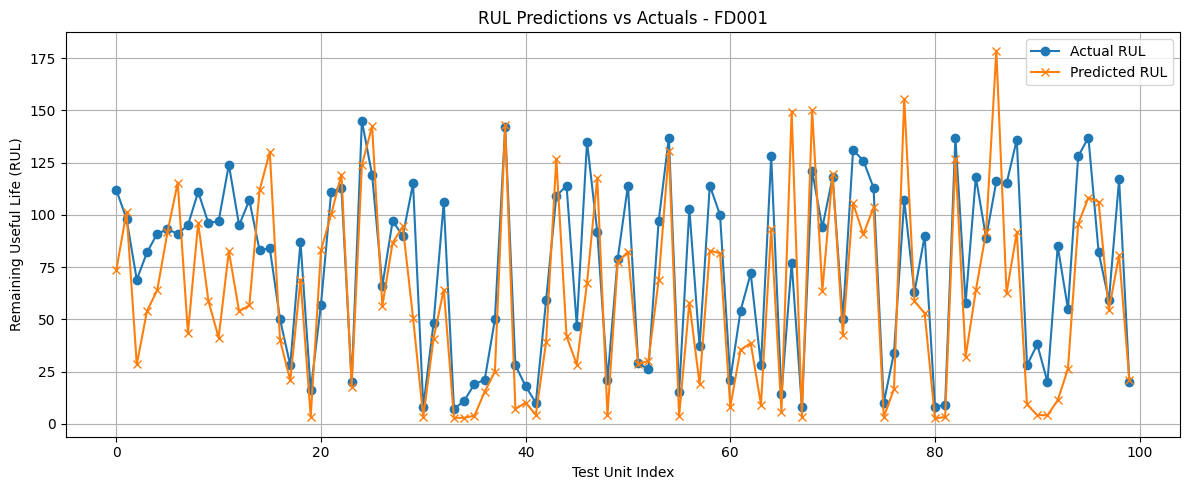

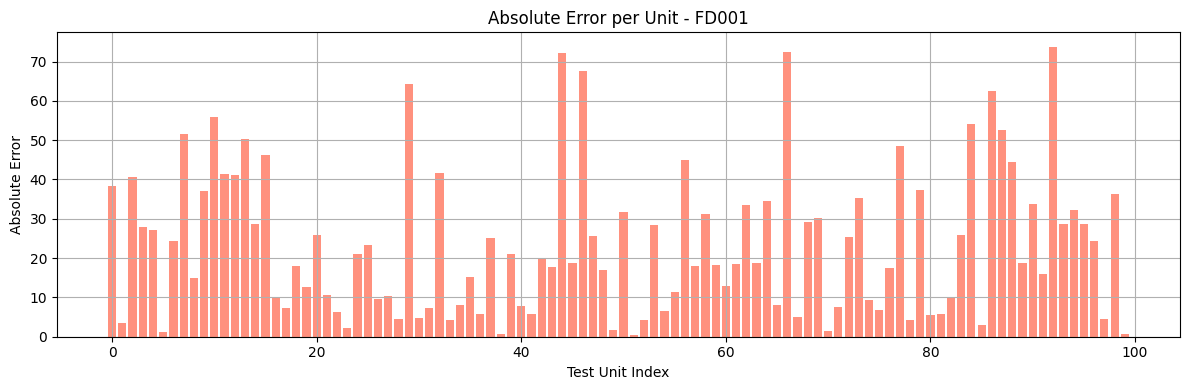


🔍 Predicting for FD002...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Unit 1: Actual RUL = 18.0, Predicted RUL = 8.3
Unit 2: Actual RUL = 79.0, Predicted RUL = 123.4
Unit 3: Actual RUL = 106.0, Predicted RUL = 106.6
Unit 4: Actual RUL = 110.0, Predicted RUL = 51.9
Unit 5: Actual RUL = 15.0, Predicted RUL = 15.9
Unit 6: Actual RUL = 155.0, Predicted RUL = 143.1
Unit 7: Actual RUL = 6.0, Predicted RUL = 6.8
Unit 8: Actual RUL = 90.0, Predicted RUL = 56.1
Unit 9: Actual RUL = 11.0, Predicted RUL = 7.8
Unit 10: Actual RUL = 79.0, Predicted RUL = 109.8
Unit 11: Actual RUL = 6.0, Predicted RUL = 7.2
Unit 12: Actual RUL = 73.0, Predicted RUL = 108.3
Unit 13: Actual RUL = 30.0, Predicted RUL = 22.1
Unit 14: Actual RUL = 11.0, Predicted RUL = 7.1
Unit 15: Actual RUL = 37.0, Predicted RUL = 42.5
Unit 16: Actual RUL = 67.0, Predicted RUL = 76.2
Unit 17: Actual RUL = 68.0, Predicted RUL = 42.9
Unit 18: Actual RUL = 99.0, Predicted RUL = 170.2
Unit 19: Actual RUL = 22.0, Predicted RUL = 31.9
Unit 20: Ac

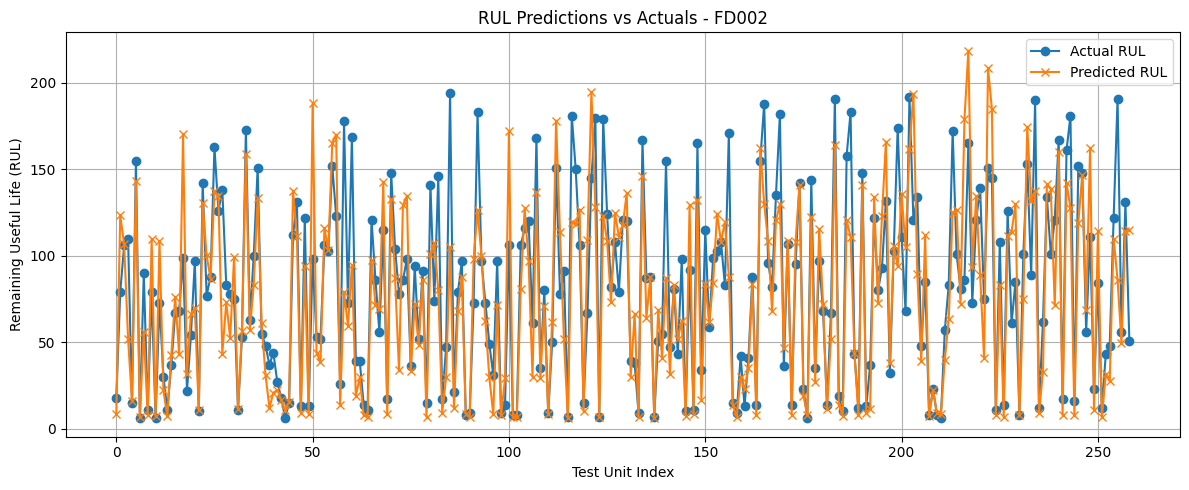

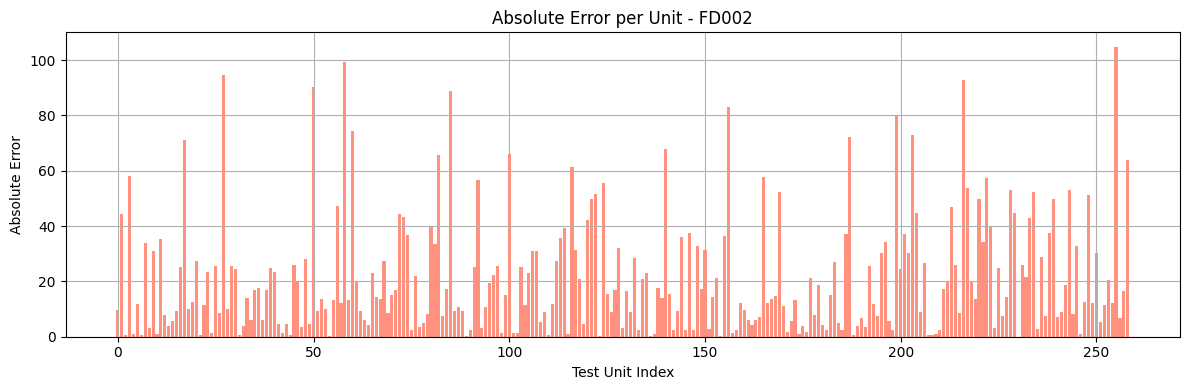


🔍 Predicting for FD003...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Unit 1: Actual RUL = 44.0, Predicted RUL = 41.5
Unit 2: Actual RUL = 51.0, Predicted RUL = 46.5
Unit 3: Actual RUL = 27.0, Predicted RUL = 14.5
Unit 4: Actual RUL = 120.0, Predicted RUL = 107.6
Unit 5: Actual RUL = 101.0, Predicted RUL = 83.4
Unit 6: Actual RUL = 99.0, Predicted RUL = 116.2
Unit 7: Actual RUL = 71.0, Predicted RUL = 29.4
Unit 8: Actual RUL = 55.0, Predicted RUL = 22.5
Unit 9: Actual RUL = 55.0, Predicted RUL = 40.9
Unit 10: Actual RUL = 66.0, Predicted RUL = 64.9
Unit 11: Actual RUL = 77.0, Predicted RUL = 65.3
Unit 12: Actual RUL = 115.0, Predicted RUL = 67.8
Unit 13: Actual RUL = 115.0, Predicted RUL = 102.4
Unit 14: Actual RUL = 31.0, Predicted RUL = 12.4
Unit 15: Actual RUL = 108.0, Predicted RUL = 100.5
Unit 16: Actual RUL = 56.0, Predicted RUL = 70.9
Unit 17: Actual RUL = 136.0, Predicted RUL = 112.6
Unit 18: Actual RUL = 132.0, Predicted RUL = 101.9
Unit 19: Actual RUL = 85.0, Predicted RUL = 109.8

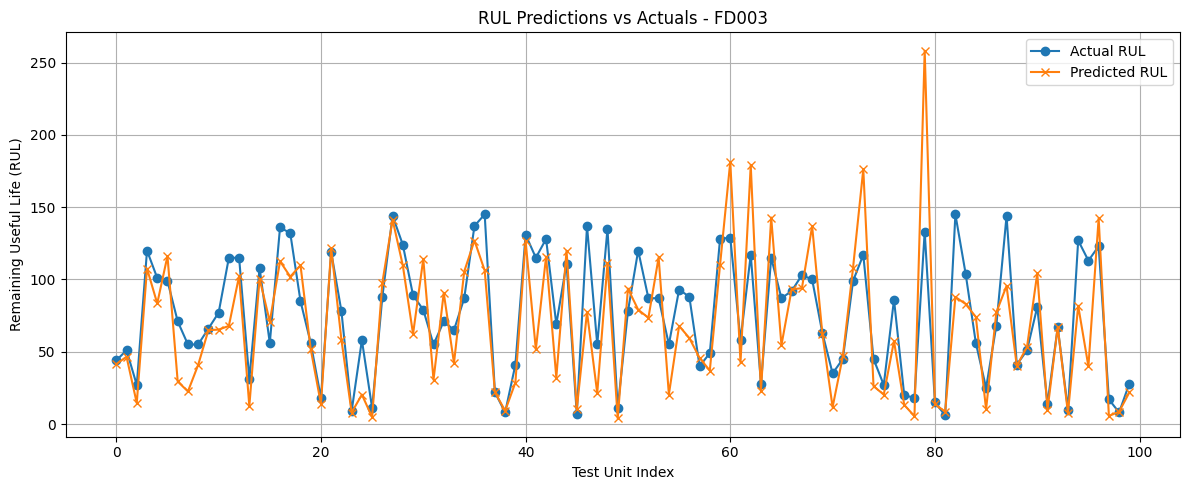

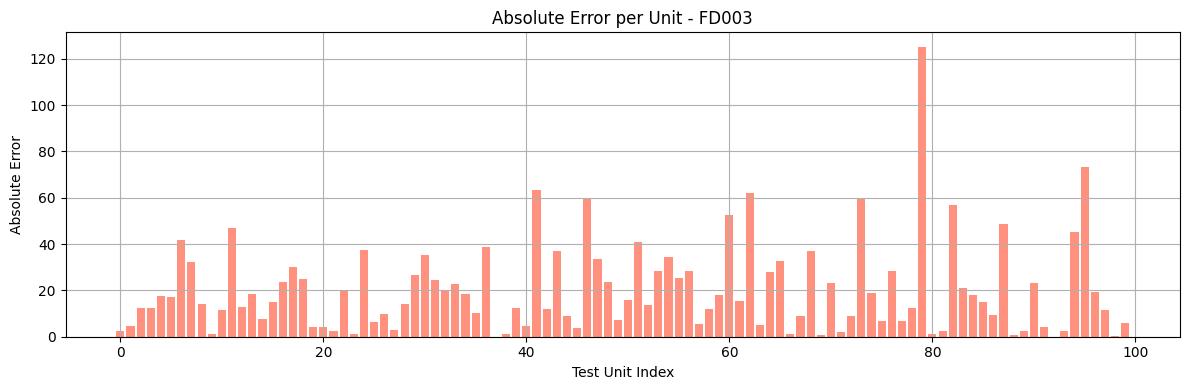


🔍 Predicting for FD004...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Unit 1: Actual RUL = 22.0, Predicted RUL = 93.6
Unit 2: Actual RUL = 39.0, Predicted RUL = 50.2
Unit 3: Actual RUL = 107.0, Predicted RUL = 87.8
Unit 4: Actual RUL = 75.0, Predicted RUL = 115.6
Unit 5: Actual RUL = 149.0, Predicted RUL = 85.0
Unit 6: Actual RUL = 78.0, Predicted RUL = 130.0
Unit 7: Actual RUL = 94.0, Predicted RUL = 75.2
Unit 8: Actual RUL = 14.0, Predicted RUL = 9.6
Unit 9: Actual RUL = 99.0, Predicted RUL = 147.3
Unit 10: Actual RUL = 162.0, Predicted RUL = 148.4
Unit 11: Actual RUL = 143.0, Predicted RUL = 164.8
Unit 12: Actual RUL = 7.0, Predicted RUL = 8.7
Unit 13: Actual RUL = 71.0, Predicted RUL = 92.0
Unit 14: Actual RUL = 105.0, Predicted RUL = 95.8
Unit 15: Actual RUL = 12.0, Predicted RUL = 27.1
Unit 16: Actual RUL = 160.0, Predicted RUL = 133.7
Unit 17: Actual RUL = 162.0, Predicted RUL = 53.7
Unit 18: Actual RUL = 104.0, Predicted RUL = 82.0
Unit 19: Actual RUL = 194.0, Predicted RUL = 170.9


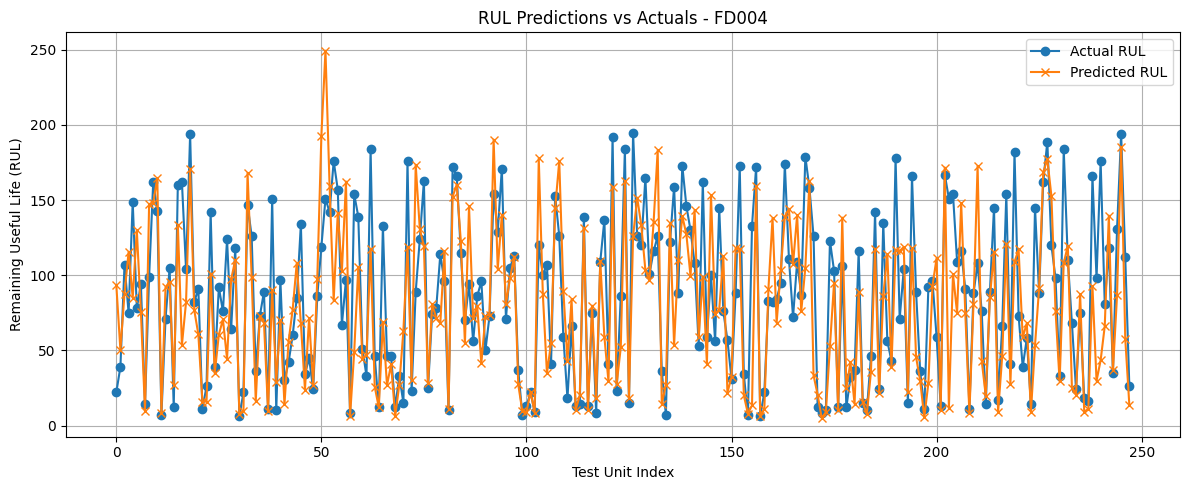

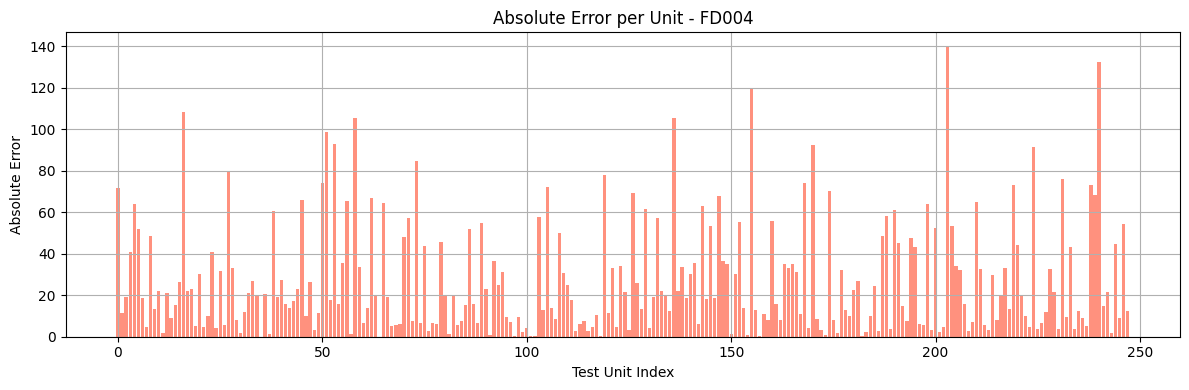


Evaluation Summary:
  Dataset          MSE        MAE
0   FD001   897.915051  23.580795
1   FD002   924.012624  21.512588
2   FD003   804.675122  20.318155
3   FD004  1479.119460  27.304270


In [90]:
results = []
for dataset in ["FD001", "FD002", "FD003", "FD004"]:
    result = predict_rul_for_dataset(index=dataset)
    if result:
        results.append(result)

if results:
    df_results = pd.DataFrame(results)
    print("\nEvaluation Summary:")
    print(df_results)